# Analisis Portofolio Kuantitatif: Modern Portfolio Theory & Efficient Frontier

**Penulis:** Muhammad Rizky Raihan
**Tanggal:** 11 Desember 2025
**Versi:** 1.0

---

## 1. Pendahuluan & Tujuan Proyek

Proyek ini bertujuan untuk membangun dan menganalisis portofolio saham menggunakan **Modern Portfolio Theory (MPT)**. MPT adalah kerangka kerja investasi yang dikembangkan oleh Harry Markowitz, yang menunjukkan bagaimana seorang investor dapat membangun portofolio optimal untuk memaksimalkan *expected return* berdasarkan tingkat risiko tertentu (diukur sebagai *variance* atau *standard deviation*).

**Tujuan Utama:**
1.  **Akuisisi Data:** Mengunduh data harga saham historis dari beberapa perusahaan teknologi besar.
2.  **Analisis Statistik:** Melakukan analisis statistik mendalam pada *logarithmic returns*, termasuk stasioneritas (Uji ADF) dan distribusi (Uji Jarque-Bera).
3.  **Kalkulasi MPT:** Menghitung *expected returns*, *covariance matrix*, *portfolio variance*, dan *portfolio returns*.
4.  **Simulasi Monte Carlo:** Menjalankan ribuan simulasi portofolio acak untuk memetakan *Efficient Frontier*.
5.  **Optimasi Portofolio:** Menemukan portofolio optimal secara matematis, termasuk:
    * **Sharpe Ratio Portfolio** (Portofolio dengan *return-to-risk* terbaik).
    * **Minimum Variance Portfolio** (Portofolio dengan risiko terendah).

**Konsep Matematika Inti:**
* **Portfolio Return ($R_p$):** $R_p = w^T \mu$
* **Portfolio Variance ($\sigma_p^2$):** $\sigma_p^2 = w^T \Sigma w$
* **Sharpe Ratio:** $\text{SR} = \frac{R_p - R_f}{\sigma_p}$

Di mana:
* $w$: Vektor bobot aset.
* $\mu$: Vektor *expected returns* aset.
* $\Sigma$: Matriks Kovariansi aset.
* $R_f$: *Risk-Free Rate*.

In [1]:
# Import library-library utama
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from datetime import datetime

# Konfigurasi plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# 1. Menentukan saham yang akan di analisis
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN','NVDA', 'TSLA', 'META']

# 2. Menentukan rentang waktu
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - pd.DateOffset(years=5)).strftime('%Y-%m-%d')

# 3. Asumsi Risk Free Rate
RISK_FREE_RATE = 0.02
print("Parameters Configuration")
print(f"Tickers: {tickers}")
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"Risk Free Rate: {RISK_FREE_RATE}")

Parameters Configuration
Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META']
Start Date: 2020-11-12
End Date: 2025-11-12
Risk Free Rate: 0.02


## 2. Akuisisi & Persiapan Data

Pada fase ini, kita akan mengunduh data harga saham historis menggunakan library `yfinance`. 

Kita secara spesifik akan mengambil harga **'Adj Close' (Adjusted Close)**. Harga ini telah disesuaikan untuk *corporate actions* seperti pembagian dividen (*dividends*) dan pemecahan saham (*stock splits*), sehingga menjadikannya data yang akurat untuk menghitung *return* investasi historis.

In [3]:
try:
    print("Mengunduh data...")
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
    adj_close_df = data['Close']
    
    if adj_close_df.isnull().values.any():
        print("\nPERINGATAN: Ditemukan nilai NaN. Memeriksa...")
        print(adj_close_df.isnull().sum())
    else:
        print("\nData berhasil diunduh dan tidak ada nilai NaN.")

    print("\nData 'Close' (Adjusted) berhasil diunduh:")
    display(adj_close_df.head())
    
    print("\nMemeriksa tipe data dan nilai non-null:")
    adj_close_df.info()

except Exception as e:
    print(f"Error saat mengunduh data: {e}")

Mengunduh data...


[*********************100%***********************]  7 of 7 completed


Data berhasil diunduh dan tidak ada nilai NaN.

Data 'Close' (Adjusted) berhasil diunduh:


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2020-11-12,116.045242,155.514008,86.544098,273.394592,206.569336,13.415796,137.253326
2020-11-13,116.093918,156.440506,88.006012,275.253143,207.595291,13.256534,136.166672
2020-11-16,117.106323,156.552994,88.093903,277.250854,208.285645,13.474118,136.029999
2020-11-17,116.220482,156.783005,87.479645,273.315125,205.629700,13.381401,147.203339
2020-11-18,114.896576,155.272995,86.435844,270.303680,202.918716,13.387880,162.213333



Memeriksa tipe data dan nilai non-null:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2020-11-12 to 2025-11-11
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1255 non-null   float64
 1   AMZN    1255 non-null   float64
 2   GOOGL   1255 non-null   float64
 3   META    1255 non-null   float64
 4   MSFT    1255 non-null   float64
 5   NVDA    1255 non-null   float64
 6   TSLA    1255 non-null   float64
dtypes: float64(7)
memory usage: 78.4 KB


## 3. Analisis Data Eksploratif (EDA) & Statistik Return

Harga saham mentah (seperti yang kita lihat di atas) **tidak stasioner** (*non-stationary*). Artinya, rata-rata (mean) dan varians (variance) mereka berubah seiring waktu (mereka memiliki *trend* naik atau turun). Model MPT dan sebagian besar analisis deret waktu finansial tidak dapat bekerja langsung pada data yang tidak stasioner.

Oleh karena itu, kita harus mengubah data harga menjadi **return**. Kita akan menggunakan **Logarithmic Returns (Log Returns)** karena dua alasan utama:
1.  **Stasioneritas:** Log returns cenderung stasioner, yang memungkinkan kita menerapkan model statistik.
2.  **Aditif:** Log return bersifat aditif terhadap waktu. Log return selama seminggu adalah jumlah dari log return harian.

Formula untuk Log Return adalah:
$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$
Di mana $P_t$ adalah harga pada hari $t$ dan $P_{t-1}$ adalah harga pada hari sebelumnya.

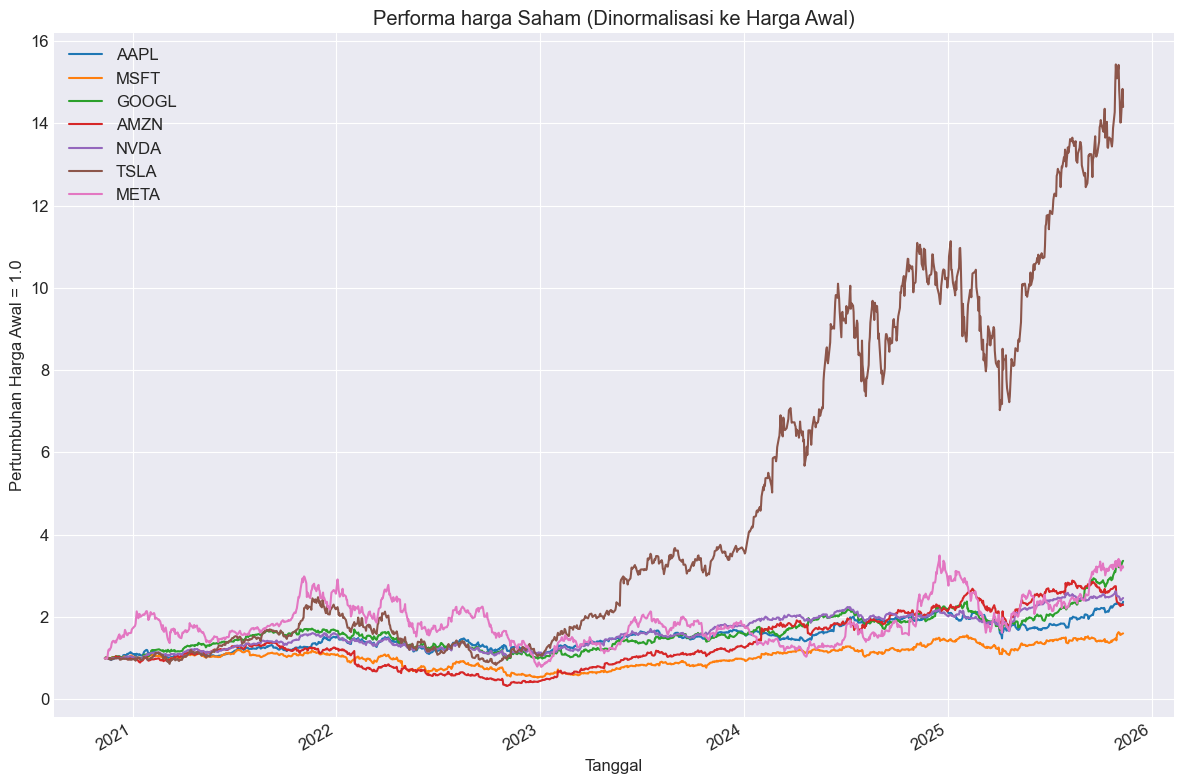


Log Returns Harian (5 baris pertama):
Ticker          AAPL      AMZN     GOOGL      META      MSFT      NVDA  \
Date                                                                     
2020-11-13  0.000419  0.005940  0.016751  0.006775  0.004954 -0.011942   
2020-11-16  0.008683  0.000719  0.000998  0.007232  0.003320  0.016280   
2020-11-17 -0.007593  0.001468 -0.006997 -0.014297 -0.012833 -0.006905   
2020-11-18 -0.011457 -0.009678 -0.012004 -0.011079 -0.013271  0.000484   
2020-11-19  0.005155  0.003716  0.010248  0.003560  0.006328  0.000856   

Ticker          TSLA  
Date                  
2020-11-13 -0.007949  
2020-11-16 -0.001004  
2020-11-17  0.078939  
2020-11-18  0.097097  
2020-11-19  0.025622  

Statistik Deskriptif Log Returns:


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
count,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000
mean,0.000689,0.000376,0.000968,0.000662,0.000719,0.002127,0.000928
std,0.017654,0.022048,0.019437,0.027617,0.016134,0.032540,0.038471
min,-0.097013,-0.151398,-0.099924,-0.306391,-0.080295,-0.185946,-0.167546
25%,-0.008056,-0.011009,-0.009484,-0.011582,-0.007421,-0.015906,-0.020263
50%,0.001139,0.000423,0.001536,0.000683,0.000706,0.002900,0.001477
75%,0.010054,0.012338,0.011311,0.013797,0.009868,0.021020,0.021985
max,0.142617,0.126949,0.097348,0.209308,0.096525,0.218088,0.204491


In [4]:
# 1. Plot harga 'Adj Close' mentah untuk melihat tren non-stasioner

(adj_close_df / adj_close_df.iloc[0]).plot(figsize=(12,8))
plt.title("Performa harga Saham (Dinormalisasi ke Harga Awal)")
plt.ylabel("Pertumbuhan Harga Awal = 1.0")
plt.xlabel("Tanggal")
plt.legend(tickers)
plt.tight_layout()
plt.show()

# 2. Menghitung return harian
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

# 3. Hapus Baris Pertama
log_returns = log_returns.dropna()

print("\nLog Returns Harian (5 baris pertama):")
print(log_returns.head())

print("\nStatistik Deskriptif Log Returns:")
display(log_returns.describe())

## 3.1. Uji Statistik Formal: Stasioneritas (ADF Test)

Kita telah mengubah harga menjadi *log returns* dengan hipotesis bahwa ini akan membuat data kita **stasioner**. Sekarang, kita harus *membuktikan* asumsi ini secara ilmiah.

Kita akan menggunakan **Augmented Dickey-Fuller (ADF) Test**, salah satu uji statistik paling umum untuk stasioneritas.

**Hipotesis Uji (ADF):**
* **$H_0$ (Hipotesis Nol):** Data *memiliki unit root* (yaitu, tidak stasioner).
* **$H_a$ (Hipotesis Alternatif):** Data *tidak memiliki unit root* (yaitu, stasioner).

**Tujuan Kita:** Kita ingin **menolak $H_0$**. Secara statistik, ini berarti kita mencari **p-value < 0.05**.

In [8]:
from statsmodels.tsa.stattools import adfuller

def run_adf_test(series, ticker_name):
    """
    Menjalankan ADF test pada series data dan mencetak hasilnya
    dengan format yang mudah dibaca.
    """
    print(f"--- Menganalisis {ticker_name} ---")
    
    # Menjalankan ADF test
    # autolag='AIC' berarti model secara otomatis memilih jumlah lag
    # yang optimal berdasarkan Akaike Information Criterion
    result = adfuller(series, autolag='AIC')
    
    p_value = result[1]
    adf_statistic = result[0]
    
    print(f'ADF Statistic: {adf_statistic:.4f}')
    print(f'P-value: {p_value:.6f}')
    
    # Interpretasi hasil
    if p_value < 0.05:
        print(f"Hasil: Stasioner (Menolak H0 pada signifikansi 5%)")
    else:
        print(f"Hasil: Tidak Stasioner (Gagal menolak H0 pada signifikansi 5%)")
    print("-" * 30)

# Menjalankan tes untuk setiap ticker di log_returns
print("Menjalankan Augmented Dickey-Fuller (ADF) Test pada Log Returns:")
for ticker in log_returns.columns:
    run_adf_test(log_returns[ticker], ticker)

Menjalankan Augmented Dickey-Fuller (ADF) Test pada Log Returns:
--- Menganalisis AAPL ---
ADF Statistic: -34.8244
P-value: 0.000000
Hasil: Stasioner (Menolak H0 pada signifikansi 5%)
------------------------------
--- Menganalisis AMZN ---
ADF Statistic: -35.9130
P-value: 0.000000
Hasil: Stasioner (Menolak H0 pada signifikansi 5%)
------------------------------
--- Menganalisis GOOGL ---
ADF Statistic: -21.8686
P-value: 0.000000
Hasil: Stasioner (Menolak H0 pada signifikansi 5%)
------------------------------
--- Menganalisis META ---
ADF Statistic: -35.9544
P-value: 0.000000
Hasil: Stasioner (Menolak H0 pada signifikansi 5%)
------------------------------
--- Menganalisis MSFT ---
ADF Statistic: -22.5975
P-value: 0.000000
Hasil: Stasioner (Menolak H0 pada signifikansi 5%)
------------------------------
--- Menganalisis NVDA ---
ADF Statistic: -21.4717
P-value: 0.000000
Hasil: Stasioner (Menolak H0 pada signifikansi 5%)
------------------------------
--- Menganalisis TSLA ---
ADF Stat

**ANALISIS**
- Temuan: Semua saham memiliki `p-value < 0.05`, yang berarti menolak $H_0$.
- Interpretasi: Karena `p-value < 0.05`, kita **Secara statistik menolak hipotesis nol ($H_0$)**.
- Kesimpulan: Log Returns bersifat **stasioner**.

---

## 3.2. Uji Statistik Formal: Normalitas (Jarque-Bera Test) & Visualisasi

Teori Portofolio Modern (MPT) klasik mengasumsikan bahwa *return* aset terdistribusi secara **normal** (yaitu, mengikuti *Gaussian distribution* atau "kurva lonceng").

Namun, dalam keuangan di dunia nyata, *return* seringkali menunjukkan:
1.  **Skewness:** Distribusi yang "miring" ke kiri atau kanan.
2.  **Kurtosis (Leptokurtosis):** Distribusi yang lebih "runcing" dengan "ekor gemuk" (*fat tails*), yang berarti peristiwa ekstrem (pergerakan harga besar) terjadi lebih sering daripada yang diprediksi oleh distribusi normal.

Kita akan menguji ini secara visual dengan **Histogram** dan secara statistik dengan **Jarque-Bera (JB) Test**.

**Hipotesis Uji (Jarque-Bera):**
* **$H_0$ (Hipotesis Nol):** Data terdistribusi normal (Skewness = 0, Kurtosis = 3).
* **$H_a$ (Hipotesis Alternatif):** Data *tidak* terdistribusi normal.

**Tujuan Kita:** Kita *menduga* akan **menolak $H_0$** (p-value < 0.05), yang membuktikan bahwa *return* saham tidak normal sempurna.

Menjalankan Jarque-Bera Test pada Log Returns:


,Ticker,JB Statistic,P-Value,Skewness,Kurtosis,Is Normal (α=0.05)
0,AAPL,1483.745958,0.000000e+00,0.251198,8.305153,False
1,AMZN,1437.795379,0.000000e+00,-0.092854,8.242435,False
2,GOOGL,541.194569,3.027559e-118,-0.063423,6.215852,False
3,META,36961.113162,0.000000e+00,-1.219916,29.484655,False
4,MSFT,484.634957,5.792369e-106,0.084847,6.040808,False
5,NVDA,726.773830,1.524292e-158,0.228158,6.701530,False
6,TSLA,307.787527,1.461462e-67,0.088120,5.420663,False


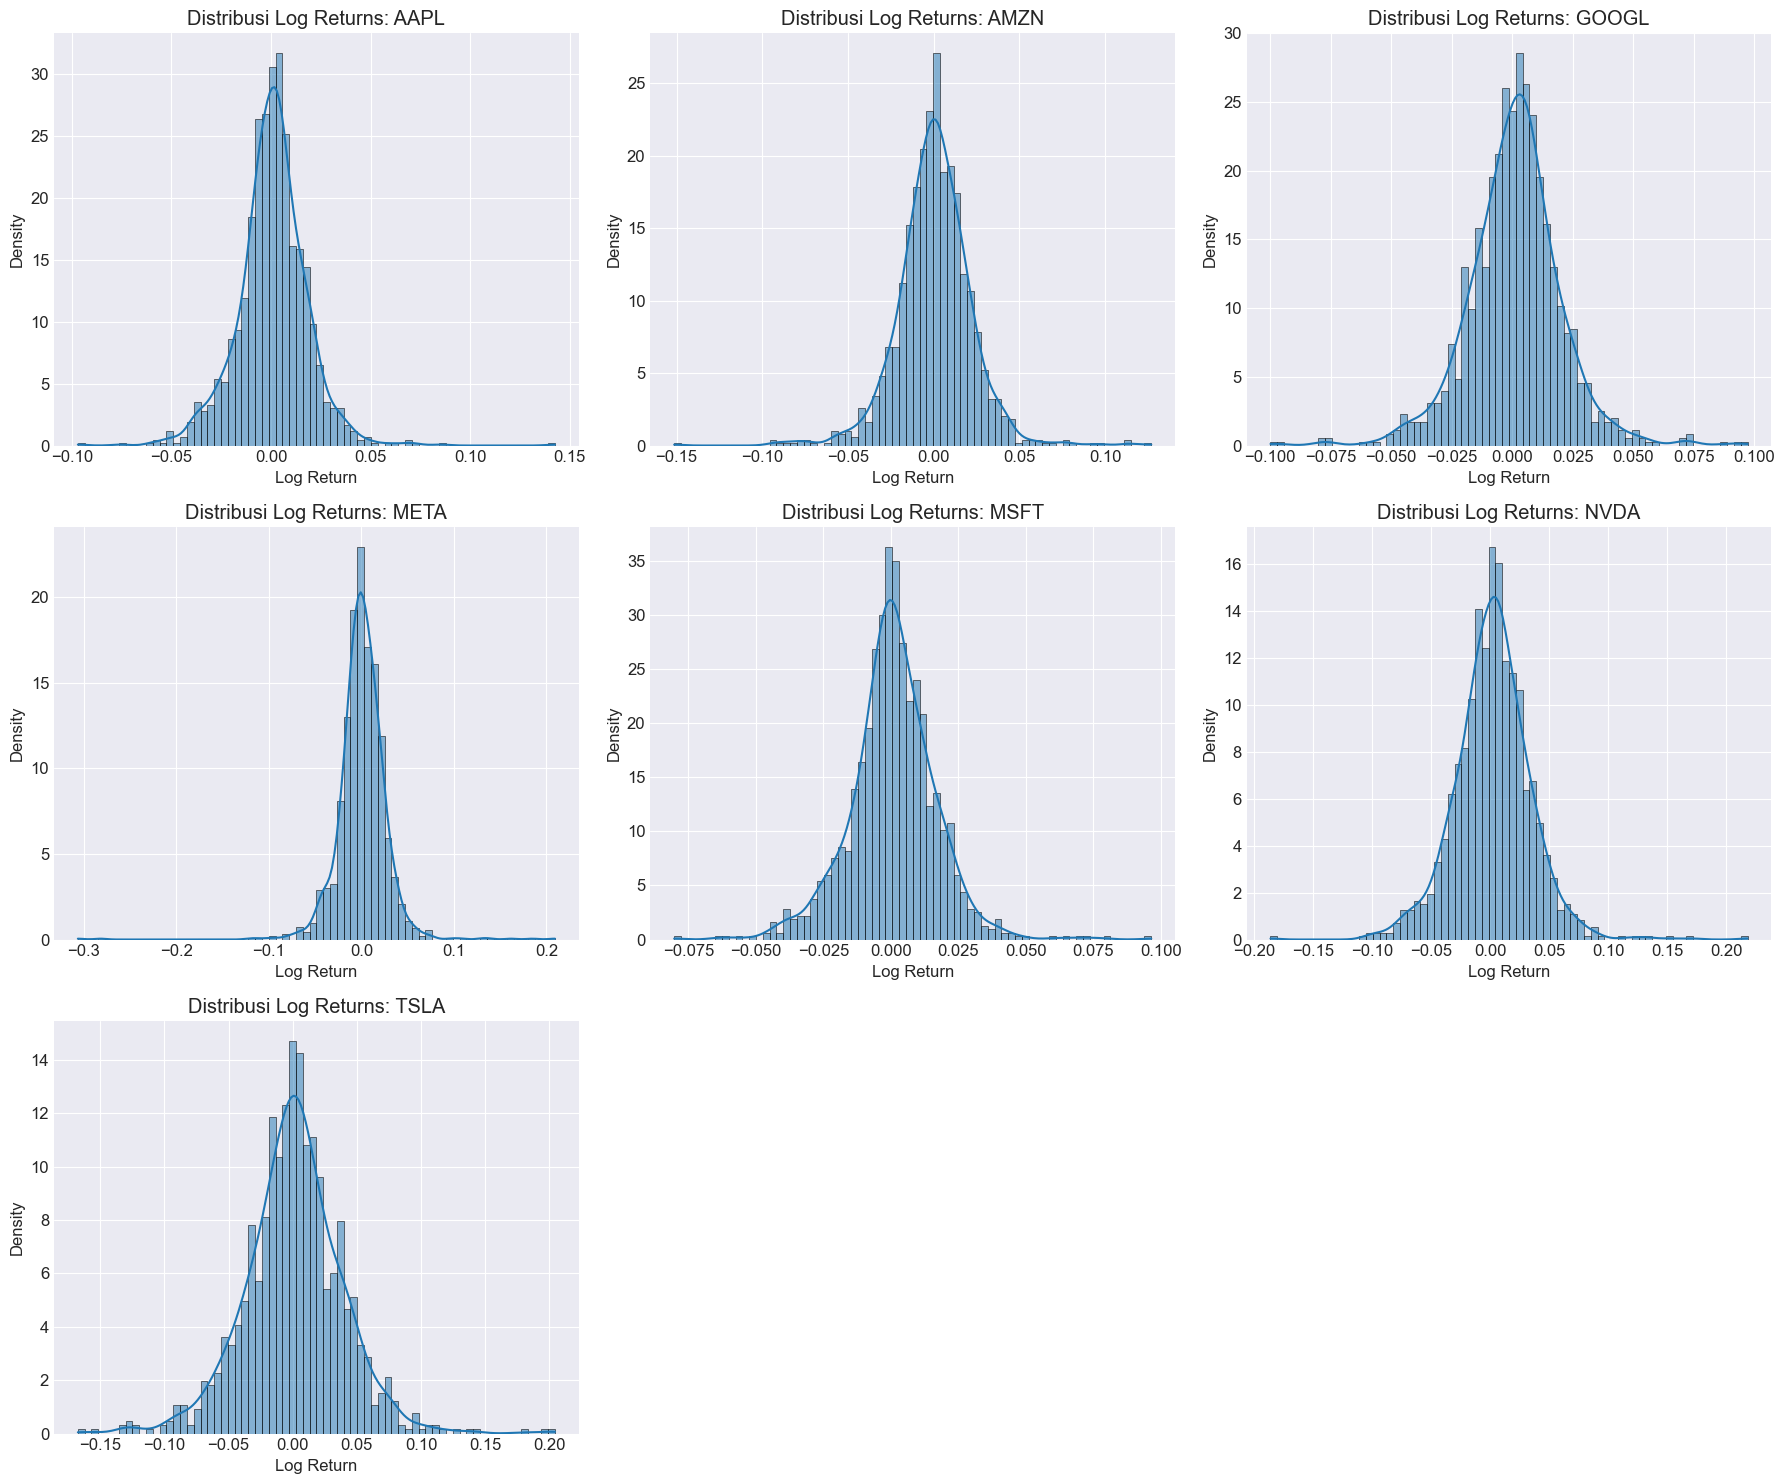

In [10]:
from statsmodels.stats.stattools import jarque_bera

print("Menjalankan Jarque-Bera Test pada Log Returns:")

# Menyiapkan list untuk menampung hasil
jb_results = []

for ticker in log_returns.columns:
  # Mengambil data log returns untuk ticker
  returns_data = log_returns[ticker]
  
  # Menjalankan Jarque-Bera Test
  jb_stat, jb_pvalue, skew, kurt = jarque_bera(returns_data)
  
  # Menyimpan hasil dalam dictionary
  jb_results.append({
      'Ticker': ticker,
      'JB Statistic': jb_stat,
      'P-Value': jb_pvalue,
      'Skewness': skew,
      'Kurtosis': kurt,
      'Is Normal (α=0.05)': jb_pvalue > 0.05
  })
  
jb_df = pd.DataFrame(jb_results)
display(jb_df)

#Visualisasi Distribusi Log Returns
fig, axes = plt.subplots(3,3, figsize=(18, 15), sharex=False, sharey=False)

axes_flat = axes.flatten()

for i, ticker in enumerate(log_returns.columns):
  ax = axes_flat[i]
  sns.histplot(log_returns[ticker], kde=True, bins=70, ax=ax, stat="density")
  ax.set_title(f'Distribusi Log Returns: {ticker}')
  ax.set_xlabel('Log Return')
  ax.set_ylabel('Density')
  
  for i in range(len(log_returns.columns), len(axes_flat)):
    axes_flat[i].set_visible(False)
    
plt.tight_layout()
plt.show()

**ANALISIS**
- Temuan (Tabel): Sebagian besar saham memiliki `p-value < 0.05`, yang berarti menolak $H_0$.
- Temuan (Statistik): `Kurtosis` untuk semua saham secara signifikan lebih besar dari 3, pada `META` yang memiliki kurtosis ekstrim `29.48`, menunjukkan fat tails yang kuat. `skewness` ada pada `~ -1.22`, menunjukkan kemiringan negatif yang kuat.
- Interpretasi: Karena `p-value < 0.05` untuk sebagian besar saham, kita **Secara statistik menolak hipotesis nol ($H_0$)**.
- Kesimpulan: Data Log Returns **tidak terdistribusi normal**. Secara spesifik, data ini bersifat **leptokurtik** (lebih runcing di tengah dan memiliki fat tails).

---

## 4. Perhitungan Komponen Modern Portfolio Theory (MPT)

Setelah menyelesaikan EDA, kita sekarang akan menghitung dua komponen utama yang diperlukan untuk MPT:

1.  **Expected Annualized Returns ($\mu$):** Rata-rata *return* yang kita harapkan dari setiap aset selama satu tahun.
2.  **Annualized Covariance Matrix ($\Sigma$):** Matriks yang mengukur bagaimana setiap aset bergerak relatif terhadap satu sama lain dalam basis tahunan. Ini adalah "mesin" dari diversifikasi.

Data `log_returns` kita saat ini dalam basis *harian*. Kita harus mengkonversinya ke basis *tahunan* (annualized) agar bermakna. Kita akan mengasumsikan ada **252 hari perdagangan** dalam setahun (angka standar industri).

**Formula:**
* **Annualized Return:** $R_{\text{annual}} = \text{mean}(r_{\text{daily}}) \times 252$
* **Annualized Covariance:** $\Sigma_{\text{annual}} = \text{Cov}(r_{\text{daily}}) \times 252$

In [11]:
# Asumsi 252 hari perdagangan dalam setahun
TRADING_DAYS = 252

# 1. Hitung Expected Annualized Returns (mu)
# Ini adalah vektor (Series) dari rata-rata return harian dikalikan 252
mu = log_returns.mean() * TRADING_DAYS

print("Expected Annualized Returns (mu):")
print("(Ini adalah komponen R_p = w^T * mu)")
display(mu)

# 2. Hitung Annualized Covariance Matrix (Sigma)
# Ini adalah matriks 7x7
Sigma = log_returns.cov() * TRADING_DAYS

print("\nAnnualized Covariance Matrix (Sigma):")
print("(Ini adalah komponen sigma_p^2 = w^T * Sigma * w)")
display(Sigma)

Expected Annualized Returns (mu):
(Ini adalah komponen R_p = w^T * mu)


Ticker
AAPL     0.173566
AMZN     0.094675
GOOGL    0.243908
META     0.166826
MSFT     0.181099
NVDA     0.535969
TSLA     0.233930
dtype: float64


Annualized Covariance Matrix (Sigma):
(Ini adalah komponen sigma_p^2 = w^T * Sigma * w)


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Ticker,,,,,,,
AAPL,0.078535,0.054960,0.050193,0.059441,0.045646,0.074798,0.083291
AMZN,0.054960,0.122499,0.067143,0.091786,0.059176,0.101343,0.093943
GOOGL,0.050193,0.067143,0.095204,0.076254,0.052052,0.084628,0.076089
META,0.059441,0.091786,0.076254,0.192204,0.065898,0.111813,0.090700
MSFT,0.045646,0.059176,0.052052,0.065898,0.065600,0.083440,0.065083
NVDA,0.074798,0.101343,0.084628,0.111813,0.083440,0.266830,0.146949
TSLA,0.083291,0.093943,0.076089,0.090700,0.065083,0.146949,0.372962


### 4.1. Analisis Korelasi (Kunci Diversifikasi)

Kovariansi adalah inti dari risiko portofolio. Sebuah ukuran yang lebih mudah dipahami adalah **korelasi**, yang memberitahu kita *arah* dan *kekuatan* hubungan antar aset.

$$\rho_{ij} = \frac{\Sigma_{ij}}{\sigma_i \sigma_j}$$

* $\rho = 1$: Korelasi positif sempurna (aset bergerak bersama).
* $\rho = -1$: Korelasi negatif sempurna (aset bergerak berlawanan).
* $\rho = 0$: Tidak ada korelasi.

**Tujuan Diversifikasi:** Kita ingin menggabungkan aset yang memiliki korelasi rendah (atau idealnya negatif) untuk mengurangi risiko portofolio secara keseluruhan.

Kita akan memvisualisasikan matriks korelasi menggunakan **heatmap**.

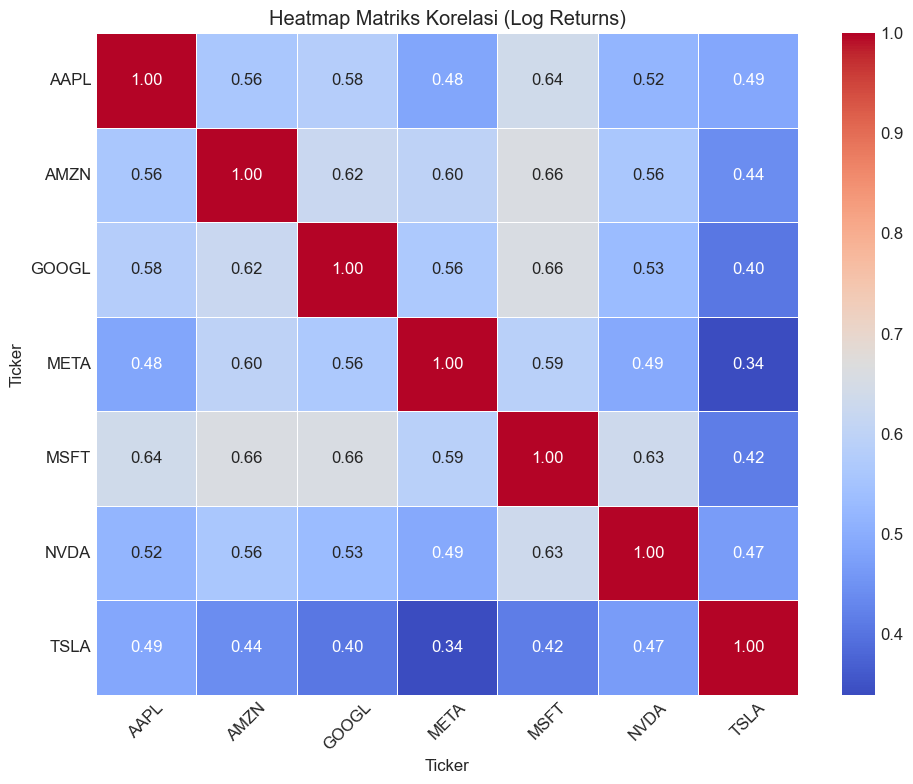

In [12]:
# Hitung Correlation Matrix (tidak perlu dikalikan 252, karena normalisasi)
corr_matrix = log_returns.corr()

# Tampilkan heatmap dari matriks korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,        # Tampilkan angka di dalam kotak
    cmap='coolwarm',   # Peta warna (biru=negatif, merah=positif)
    fmt='.2f',         # Format angka (2 desimal)
    linewidths=0.5
)
plt.title('Heatmap Matriks Korelasi (Log Returns)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()